In [45]:
import sys
# Import local version of shap
sys.path.insert(0, "/projects/leelab3/hughchen/shap")
import shap

import os
import pickle
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

from model import fit_mlp

df = pd.read_csv("data/heloc_dataset_v1.csv")

# Peel off output
y = df["RiskPerformance"] == "Good"
X = df.drop(columns=["RiskPerformance", "ExternalRiskEstimate"])

# Train test split
X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Train validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trval, y_trval, test_size=0.33, random_state=42)

fraud_feats  = [
    "MSinceOldestTradeOpen", 
    "MSinceMostRecentTradeOpen", 
    "NumTradesOpeninLast12M", 
#     "MSinceMostRecentInqexcl7days", 
#     "NumInqLast6M", 
#     "NumInqLast6Mexcl7days"
]

credit_feats = [
    "AverageMInFile", 
    "NumSatisfactoryTrades", 
    "NumTrades60Ever2DerogPubRec", 
    "NumTrades90Ever2DerogPubRec", 
    "PercentTradesNeverDelq", 
    "MSinceMostRecentDelq", 
    "MaxDelq2PublicRecLast12M", 
    "MaxDelqEver", 
    "NumTotalTrades"
]

# Split off fraud detection features
X_train_fraud = X_train[fraud_feats]
X_valid_fraud = X_valid[fraud_feats]
X_test_fraud  = X_test[fraud_feats]

# Split off credit score features
X_train_credit = X_train[credit_feats]
X_valid_credit = X_valid[credit_feats]
X_test_credit  = X_test[credit_feats]

# Split off remaining features
X_train_bank = X_train.drop(columns=fraud_feats+credit_feats)
X_valid_bank = X_valid.drop(columns=fraud_feats+credit_feats)
X_test_bank  = X_test.drop(columns=fraud_feats+credit_feats)

### Fit fraud model

In [46]:
fraud_mod_path = "models/fraud_mod.p"
if os.path.exists(fraud_mod_path):
    fraud_mod = pickle.load(open(fraud_mod_path, "rb"))
else:
    fraud_mod = XGBClassifier()
    fraud_mod.fit(X_train_fraud, y_train, eval_set=[(X_valid_fraud, y_valid)], verbose=False)
    pickle.dump(fraud_mod, open(fraud_mod_path, "wb"))

print("train roc", roc_auc_score(y_train,fraud_mod.predict_proba(X_train_fraud)[:,1]))
print("test roc ", roc_auc_score(y_test,fraud_mod.predict_proba(X_test_fraud)[:,1]))

# fraud_mod = fit_mlp(X_train_fraud, y_train)

# print("train roc", roc_auc_score(y_train,fraud_mod.predict(X_train_fraud)))
# print("test roc ", roc_auc_score(y_test,fraud_mod.predict(X_test_fraud)))

train roc 0.8362456810329151
test roc  0.5719169331547282


### Fit credit model

In [49]:
from keras.models import load_model
credit_mod_path = "models/credit_mod.h5"
if os.path.exists(credit_mod_path):
    credit_mod = load_model(credit_mod_path)
else:
    credit_mod = fit_mlp(X_train_credit, y_train)
    credit_mod.save(credit_mod_path)

print("train roc", roc_auc_score(y_train,credit_mod.predict(X_train_credit)))
print("test roc ", roc_auc_score(y_test,credit_mod.predict(X_test_credit)))

train roc 0.7171757592289507
test roc  0.7003708557725876


### Fit bank model

In [50]:
### Add consumer scores to bank data
# Add fraud scores
fraud_train_score = fraud_mod.predict(X_train_fraud,output_margin=True)
fraud_valid_score = fraud_mod.predict(X_valid_fraud,output_margin=True)
fraud_test_score  = fraud_mod.predict(X_test_fraud,output_margin=True)
X_train_bank["FraudScore"] = fraud_train_score
X_valid_bank["FraudScore"] = fraud_valid_score
X_test_bank["FraudScore"]  = fraud_test_score

# Add credit scores
credit_train_score = credit_mod.predict(X_train_credit)
credit_valid_score = credit_mod.predict(X_valid_credit)
credit_test_score  = credit_mod.predict(X_test_credit)
X_train_bank["CreditScore"] = credit_train_score
X_valid_bank["CreditScore"] = credit_valid_score
X_test_bank["CreditScore"]  = credit_test_score

# Meta model
bank_mod = XGBClassifier()
bank_mod.fit(X_train_bank, y_train, eval_set=[(X_valid_bank, y_valid)], verbose=False)

print("train roc", roc_auc_score(y_train,bank_mod.predict_proba(X_train_bank)[:,1]))
print("test roc ", roc_auc_score(y_test,bank_mod.predict_proba(X_test_bank)[:,1]))

train roc 0.9960858337879614
test roc  0.6777086257295668


### Split out explicands and references

In [56]:
np.random.seed(320)
# Get explicands and references
expl_num  = 1000
refe_num  = 100
expl_inds = np.random.choice(np.arange(X_train_bank.shape[0]),size=expl_num,replace=False)
refe_inds = np.random.choice(np.arange(X_train_bank.shape[0]),size=refe_num,replace=False)

expl_frau = X_train_fraud.iloc[expl_inds]
refe_frau = X_train_fraud.iloc[refe_inds]
expl_cred = X_train_credit.iloc[expl_inds]
refe_cred = X_train_credit.iloc[refe_inds]
expl_bank = X_train_bank.iloc[expl_inds]
refe_bank = X_train_bank.iloc[refe_inds]
expl_orig = X_train.iloc[expl_inds]
refe_orig = X_train.iloc[refe_inds]

### Get attributions to original feature space

In [182]:
start = time()
explainer = shap.TreeExplainer(fraud_mod, refe_frau, feature_dependence="interventional")
attr_frau = np.swapaxes(explainer.shap_values(expl_frau, per_reference=True),1,2)
explainer = shap.DeepExplainer(credit_mod, refe_cred.values)
attr_cred = explainer.shap_values(expl_cred.values, per_reference=True)[0]
explainer = shap.TreeExplainer(bank_mod, refe_bank, feature_dependence="interventional")
attr_bank = np.swapaxes(explainer.shap_values(expl_bank, per_reference=True),1,2)

# Verify that the attributions sum up correctly
pred_diff = bank_mod.predict(expl_bank,output_margin=True)-\
    bank_mod.predict(refe_bank,output_margin=True).mean()
attr_sums = attr_bank.mean(1).sum(1)
assert np.allclose(pred_diff,attr_sums,atol=.0001)

preds_diff = credit_mod.predict(expl_cred)[:,0]-\
    credit_mod.predict(refe_cred)[:,0].mean()
assert np.allclose(preds_diff,attr_cred.mean(1).sum(1),atol=.0001)

preds_diff = fraud_mod.predict(expl_frau, output_margin=True)-\
    fraud_mod.predict(refe_frau, output_margin=True).mean()
assert np.allclose(preds_diff,attr_frau.mean(1).sum(1),atol=.0001)

frau_ind = expl_bank.columns.to_list().index("FraudScore")
cred_ind = expl_bank.columns.to_list().index("CreditScore")

# Rescale fraud attributions
expl_frau2 = np.repeat(fraud_mod.predict(expl_frau, output_margin=True)[:,None],refe_num,axis=1)
refe_frau2 = np.repeat(fraud_mod.predict(refe_frau, output_margin=True)[None,:],expl_num,axis=0)
denom = expl_frau2-refe_frau2
numer = attr_bank[:,:,frau_ind]
rescale = np.divide(numer, denom, out=np.zeros_like(numer), where=denom!=0) # Filter by denom. for instability
attr_frau_re = attr_frau*rescale[:,:,None]
assert np.allclose(attr_frau_re.mean(1).sum(1),attr_bank[:,:,frau_ind].mean(1),atol=0.0001)

# Rescale credit attributions
expl_cred2 = np.repeat(credit_mod.predict(expl_cred)[:,0][:,None],refe_num,axis=1)
refe_cred2 = np.repeat(credit_mod.predict(refe_cred)[:,0][None,:],expl_num,axis=0)
denom = expl_cred2-refe_cred2
numer = attr_bank[:,:,cred_ind]
rescale = np.divide(numer, denom, out=np.zeros_like(numer), where=denom!=0)  # Filter by denom. for instability
attr_cred_re = attr_cred*rescale[:,:,None]
assert np.allclose(attr_cred_re.mean(1).sum(1),attr_bank[:,:,cred_ind].mean(1),atol=0.0001)

# Get original space attributions
attr_orig = np.zeros([expl_num,refe_num,X_train.shape[1]])

cols_orig = list(X_train.columns)
cols_frau = list(X_train_fraud.columns)
cols_cred = list(X_train_credit.columns)
cols_bank = list(X_train_bank.columns)[:-2] # Pop off credit score and fraud score

for i,col in enumerate(cols_frau):
    j = cols_orig.index(col)
    attr_orig[:,:,j] = attr_frau_re[:,:,i]

for i,col in enumerate(cols_cred):
    j = cols_orig.index(col)
    attr_orig[:,:,j] = attr_cred_re[:,:,i]
    
for i,col in enumerate(cols_bank):
    j = cols_orig.index(col)
    attr_orig[:,:,j] = attr_bank[:,:,i]
    
# Verify that the attributions sum up correctly
pred_diff = bank_mod.predict(expl_bank,output_margin=True)-\
    bank_mod.predict(refe_bank,output_margin=True).mean()
attr_sums = attr_bank.mean(1).sum(1)
assert np.allclose(pred_diff,attr_sums,atol=.0001)
deep_time = time() - start

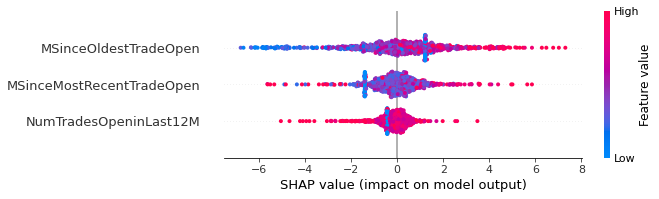

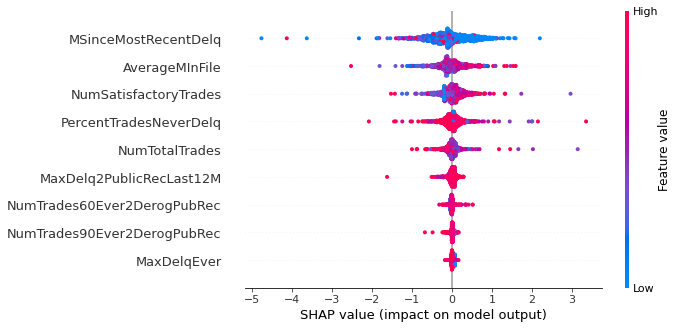

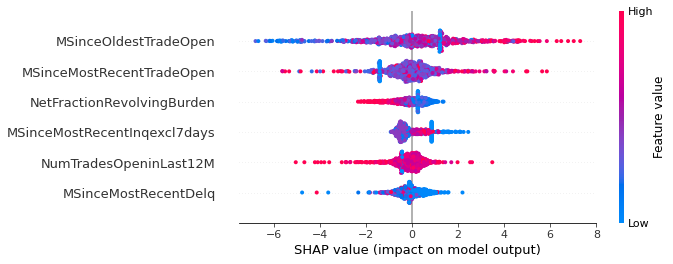

<Figure size 432x288 with 0 Axes>

In [183]:
# Save summary plots
import matplotlib.pyplot as plt
shap.summary_plot(attr_frau.mean(1),expl_frau,show=False,max_display=6)
plt.savefig("fig/attr_frau.pdf")
plt.clf()
shap.summary_plot(attr_cred.mean(1),expl_cred,show=False,max_display=6)
plt.savefig("fig/attr_cred.pdf")
plt.clf()
shap.summary_plot(attr_bank.mean(1),expl_bank,show=False,max_display=6)
plt.savefig("fig/attr_bank.pdf")
plt.clf()

# Show intermediary plots
shap.summary_plot(attr_frau_re.mean(1),expl_frau)
shap.summary_plot(attr_cred_re.mean(1),expl_cred)

# Save summary plots of original features
shap.summary_plot(attr_orig.mean(1),expl_orig,show=False,max_display=6)
plt.savefig("fig/attr_orig.pdf")
plt.show()
plt.clf()

### Get attributions from other methods

In [170]:
fraud_feat_inds  = np.array([list(X_train.columns).index(feat) for feat in fraud_feats])
credit_feat_inds = np.array([list(X_train.columns).index(feat) for feat in credit_feats])
bank_feat_inds   = np.setdiff1d(np.arange(X_train.shape[1]),np.concatenate([fraud_feat_inds, credit_feat_inds]))

def full_mod(X):
    """
    X : numpy array
    """
    if "DataFrame" in str(type(X)):
        # Split off features
        X_fraud  = X[fraud_feats]
        X_credit = X[credit_feats]
        X_bank   = X.drop(columns=fraud_feats+credit_feats)

        # Add fraud scores
        fraud_score = fraud_mod.predict(X_fraud,output_margin=True)
        X_bank["FraudScore"] = fraud_score

        # Add credit scores
        credit_score = credit_mod.predict(X_credit)
        X_bank["CreditScore"] = credit_score

        # Meta model
        return(bank_mod.predict(X_bank,output_margin=True))

    if "numpy.ndarray" in str(type(X)):
        # Split off features
        X_fraud  = X[:,fraud_feat_inds]
        X_credit = X[:,credit_feat_inds]
        X_bank   = X[:,bank_feat_inds]

        # Scores
        fraud_score = fraud_mod.predict(pd.DataFrame(X_fraud,columns=X_train_fraud.columns),output_margin=True)
        credit_score = credit_mod.predict(X_credit)

        X_bank = np.concatenate([X_bank,np.array(fraud_score)[:,None],credit_score],axis=1)
        return(bank_mod.predict(pd.DataFrame(X_bank,columns=X_train_bank.columns),output_margin=True))

In [ ]:
from deepshap.explanation import lime_wrapper
refer = refe_orig.values
expli = expl_orig.values
nsamp = 100

fname_kern = "attr/kern_attr.npy"
fname_samp = "attr/samp_attr.npy"
fname_lime = "attr/lime_attr.npy"
fname_times = "attr/runtimes.p"

if not all([os.path.exists(f) for f in [fname_kern, fname_samp, fname_lime, fname_times]]):
    start = time()
    kern_attr = shap.KernelExplainer(full_mod, refer).shap_values(expli, num_samples=nsamp)
    kern_time = time()-start

    start = time()
    samp_attr = shap.SamplingExplainer(full_mod, refer).shap_values(expli, num_samples=nsamp)
    samp_time = time()-start

    start = time()
    lime_attr = lime_wrapper(full_mod, expli, refer, mode="regression", wrap_pred=False, num_samples=nsamp)
    lime_time = time()-start

    np.save(fname_kern, kern_attr)
    np.save(fname_samp, samp_attr)
    np.save(fname_lime, lime_attr)
    runtimes = {"kern":kern_time, "samp":samp_time, "lime":lime_time}
    pickle.dump(runtimes, open(fname_times, "wb"))
else:
    kern_attr = np.load(fname_kern)
    samp_attr = np.load(fname_samp)
    lime_attr = np.load(fname_lime)
    runtimes = pickle.load(open(fname_times, "rb"))
    kern_time = runtimes["kern"]
    samp_time = runtimes["samp"]
    lime_time = runtimes["lime"]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

In [228]:
from deepshap.evaluation import ablate
single_ref = np.repeat(np.array(expli.mean(0))[np.newaxis,:],1000,0) 
deep_attr = attr_orig.mean(1)

# Colors
GREEN  = "#1ea81e"
BLUE   = "#1e88e5"
RED    = "#ff0d57"
ORANGE = "#ff8800"

In [257]:
deep_ablated_pos_output = ablate(full_mod, deep_attr, expli, impute="pos", refer=single_ref)
samp_ablated_pos_output = ablate(full_mod, samp_attr, expli, impute="pos", refer=single_ref)
kern_ablated_pos_output = ablate(full_mod, kern_attr, expli, impute="pos", refer=single_ref)
lime_ablated_pos_output = ablate(full_mod, lime_attr, expli, impute="pos", refer=single_ref)

deep_ablated_neg_output = ablate(full_mod, deep_attr, expli, impute="neg", refer=single_ref)
samp_ablated_neg_output = ablate(full_mod, samp_attr, expli, impute="neg", refer=single_ref)
kern_ablated_neg_output = ablate(full_mod, kern_attr, expli, impute="neg", refer=single_ref)
lime_ablated_neg_output = ablate(full_mod, lime_attr, expli, impute="neg", refer=single_ref)

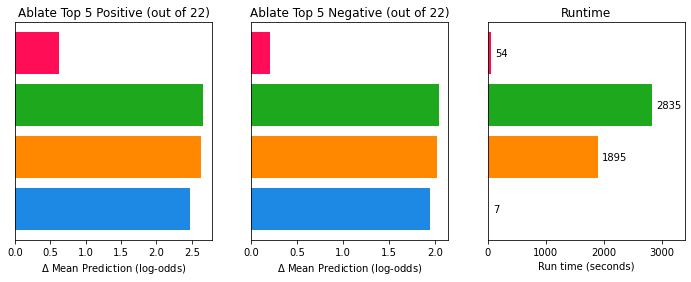

In [323]:
plt.rcParams['figure.figsize'] = 12,4
plt.subplot(1,3,1)

colors = [BLUE, ORANGE, GREEN, RED]
colors.reverse()

ablate_lst = [deep_ablated_pos_output[5], samp_ablated_pos_output[5],
              kern_ablated_pos_output[5], lime_ablated_pos_output[5]]
ablate_lst = list(np.abs(ablate_lst))
ablate_lst.reverse()
bar = plt.barh(-np.arange(4),ablate_lst,color=colors)

# plt.yticks(-np.arange(4),["DeepSHAP", "IME", "Kernel", "LIME"])
# plt.ylabel("Run time (seconds)")
plt.yticks([])
plt.xlabel("$\Delta$ Mean Prediction (log-odds)")
plt.title("Ablate Top 5 Positive (out of 22)")

plt.subplot(1,3,2)
ablate_lst = [deep_ablated_neg_output[5], samp_ablated_neg_output[5],
              kern_ablated_neg_output[5], lime_ablated_neg_output[5]]
ablate_lst = list(np.abs(ablate_lst))
ablate_lst.reverse()
bar = plt.barh(-np.arange(4),ablate_lst,color=colors)

# plt.ylabel("Run time (seconds)")
plt.yticks([])
plt.xlabel("$\Delta$ Mean Prediction (log-odds)")
plt.title("Ablate Top 5 Negative (out of 22)")

plt.subplot(1,3,3)
runtimes = [deep_time, samp_time, kern_time, lime_time]
runtimes.reverse()
bar = plt.barh(-np.arange(4),runtimes,color=colors)

for rect in bar:
    width = rect.get_width()
    plt.text(width+80, rect.get_y()+rect.get_height()*(1/2), 
             '%d' % int(width), ha='left', va='center')

plt.xlim([0,3400])
plt.yticks([])
plt.xlabel("Run time (seconds)")
plt.title("Runtime")
plt.savefig("fig/ablation_results.pdf")
plt.show()

### Fit full model

train roc 0.9955106382978722
test roc  0.7572258129891762


100%|===================| 996/1000 [00:28<00:00]        

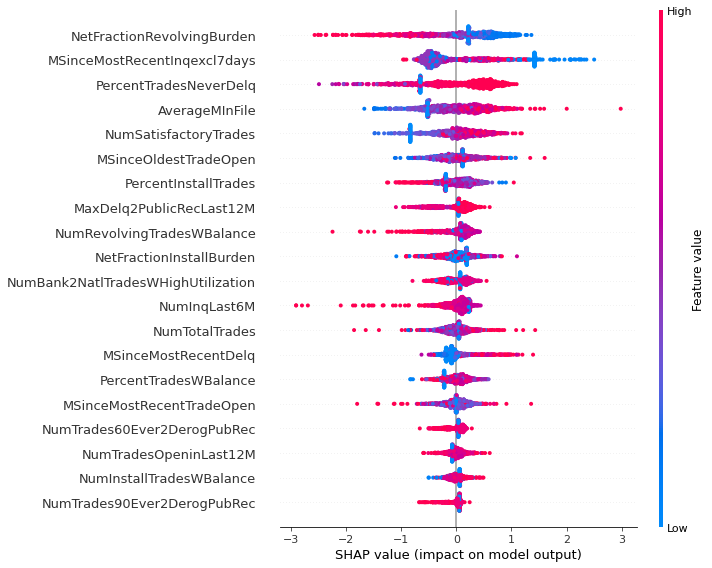

In [44]:
# Model
full_mod = XGBClassifier()
full_mod.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

print("train roc", roc_auc_score(y_train,full_mod.predict_proba(X_train)[:,1]))
print("test roc ", roc_auc_score(y_test,full_mod.predict_proba(X_test)[:,1]))

# Explain
rand_inds = np.random.choice(np.arange(X_train.shape[0]),size=1000,replace=False)
expl = X_train.iloc[rand_inds]
refe = X_train.iloc[rand_inds]
attr = shap.TreeExplainer(full_mod, refe).shap_values(expl)
shap.summary_plot(attr, expl)